# HW6
J. Sibley, 2021

In [1]:
# import block
# some of these may not be needed
import numpy as np
from astropy.io import fits
import pdb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib
from astropy.visualization import hist
from datetime import datetime
from pathlib import Path
import os
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D,Gaussian2D,Polynomial2D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData, StdDevUncertainty
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table
from imexam.imexamine import Imexamine
from astropy.coordinates import SkyCoord

# grab show_image
phot_tutorial_dir = '/Users/palladl2/Desktop/projects/astr_8060_f21/phot-tutorials/ccd-reduction-and-photometry-guide/notebooks/'

plt.style.use(phot_tutorial_dir+'guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

Ginga not installed, use other viewer, or no viewer


In [2]:
# define directories
data_dir = '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/Imaging/'
reduced_dir = '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/'


### 1. Using imexam, measure the PSF FWHM of one of the stars in the PG1633+099 Landolt standard field. Are there significant trends or variations in the FWHM for the same star observed at different times throughout the night? How about for different stars observed at similar times but different airmasses? How about across the chip in a single exposure? Make plots to support your findings regarding the variation of the PSF with time/airmass/chip location.

<b>Read in the data and plot the image</b>

In [3]:
# read in the data

nfiles = 12 # number of files in a sequence
nlow   = 81  # the exposure number for the first file 

sci_files = reduced_dir + 'a085otz.fits'

# you can use list comprehension when you need to do something many times
# one example is to use it to open all the bias files and headers
hdus = fits.open(sci_files)
hdrs = hdus[0].header
sci = hdus[0].data
#print(sci_files)

Text(0.5, 1.0, 'Delta Airmass')

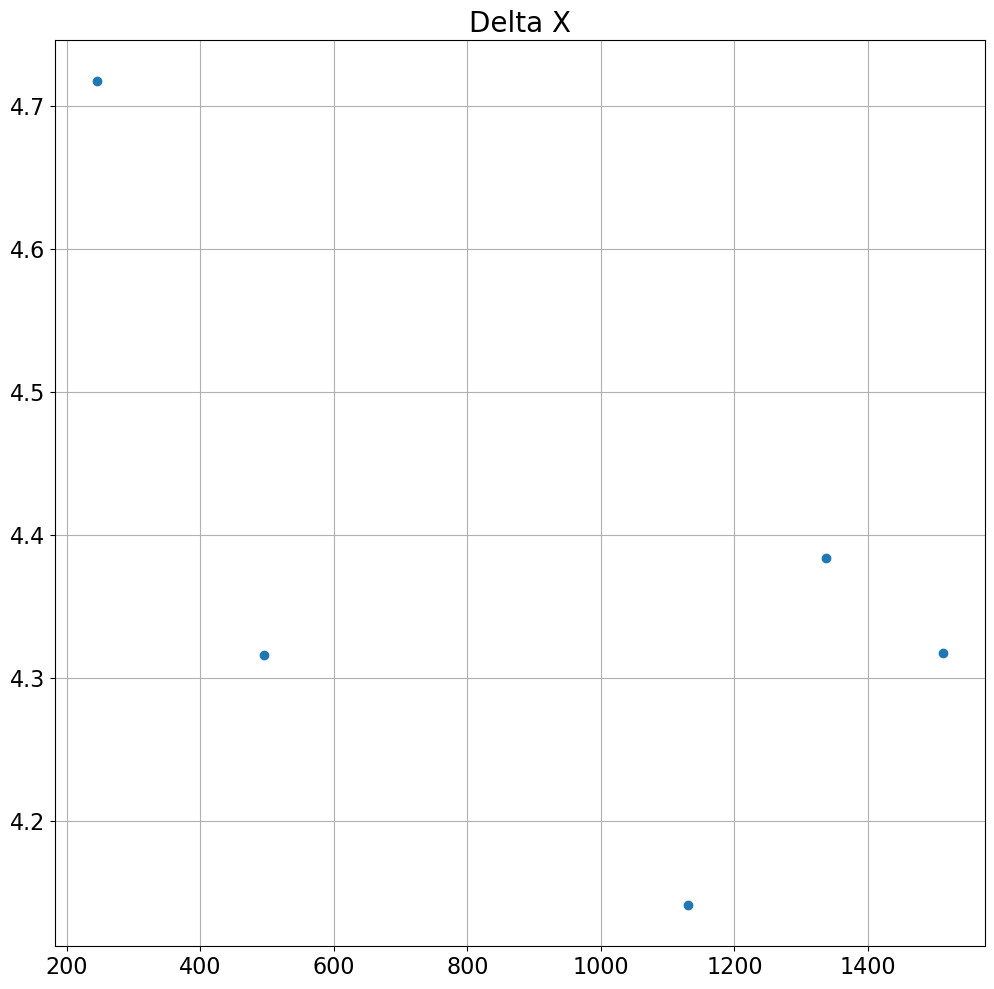

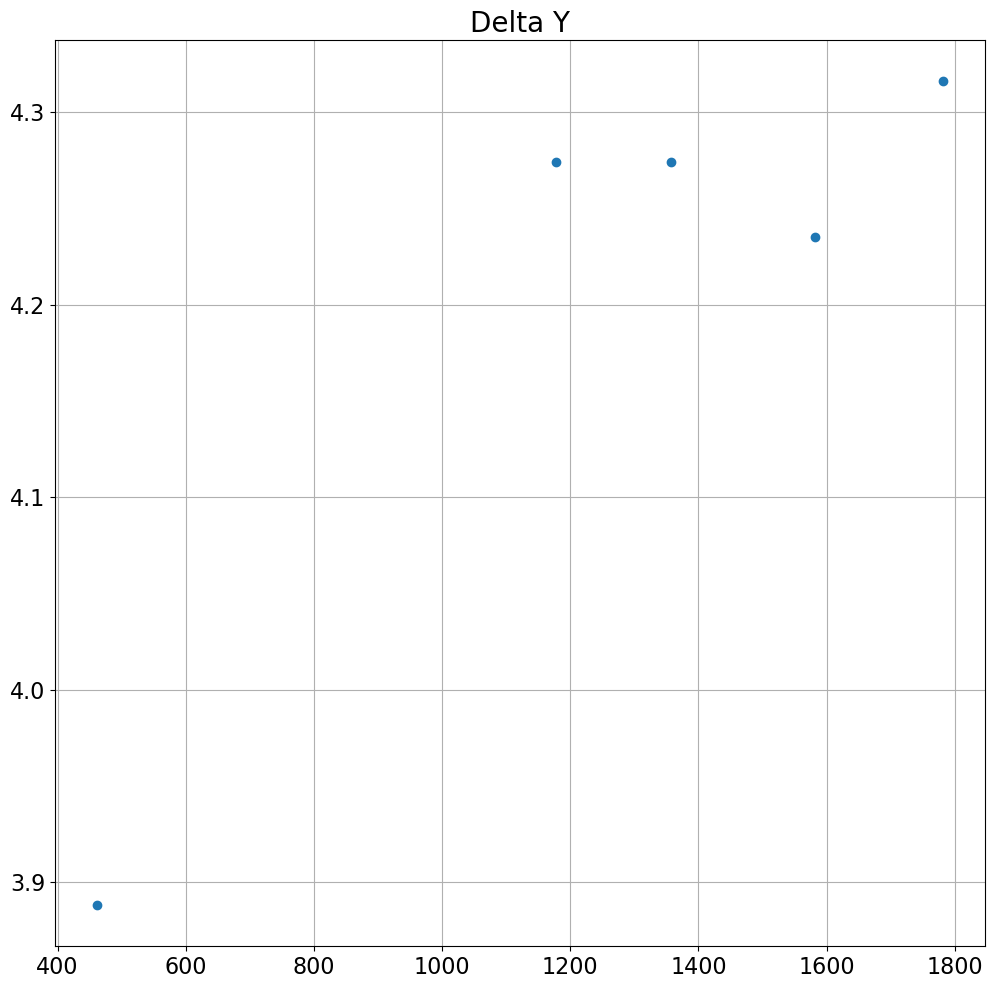

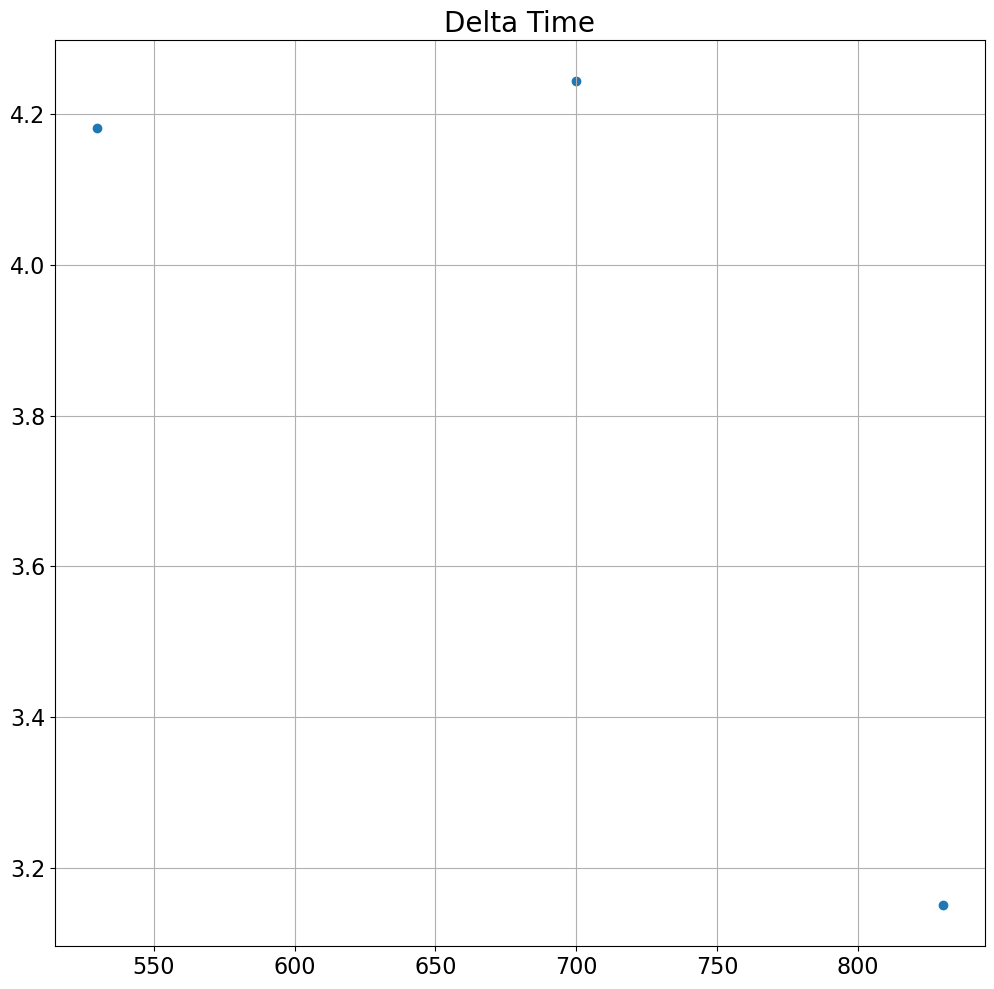

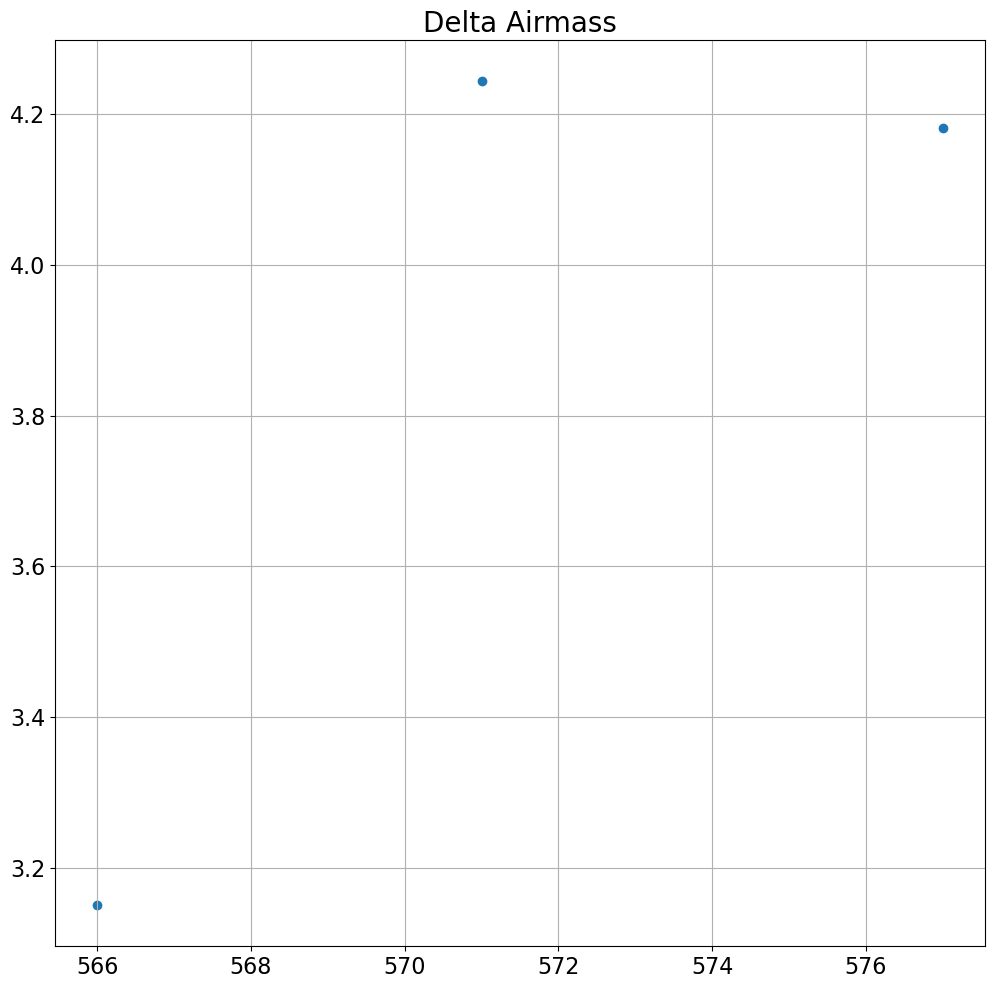

In [4]:
# We unforunately do not have a way to get the fwhm without printing these plots. 
# This is not a problem for like three to five images but if we needed to do more this ccould be problematic

plots=Imexamine() 

#x = 65
#y = 566

#plots.radial_profile(456.38397,135.73336,sci,genplot=True)

# across y  = approx. 1712

# 4.717 x = 246

# 4.316 x = 496

# 4.141 x = 1130

# 4.317 x = 1512

# 4.384 x = 1338

a1 = np.array([4.717,4.316,4.141,4.317,4.384])
a2 = np.array([246,496,1130,1512,1338])

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.scatter(a2,a1)
ax.set_title('Delta X',size=20)

# across x = approx. 497

# 4.316 y = 1781

# 4.235 y = 1582

# 4.274 y = 1357

# 4.274 y = 1177

# 3.888 y = 462

a1 = np.array([4.316,4.235,4.274,4.274,3.888])
a2 = np.array([1781,1582,1357,1177,462])

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.scatter(a2,a1)
ax.set_title('Delta Y',size=20)

# Look at the same star in different frames for the varying times, and then look at the frames with different airmasses in the log
 
    
    # @ different times
# x = 129 y = 577 approx 5:30 4.181 a085

# x = 72 y = 571 approx 7:00 4.243 a134

# x = 65 y = 566 approx 8:20 3.151 a208

a1 = np.array([530,700,830])
a2 = np.array([4.181,4.243,3.151])

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.scatter(a1,a2)
ax.set_title('Delta Time',size=20)


    # @ different airmass
# x = 129 y = 577 chi = 1.18 4.181 a085

# x = 72 y = 571  chi = 1.24 4.243 a134

# x = 65 y = 566  chi = 1.52 3.151 a208

a1 = np.array([577,571,566])
a2 = np.array([4.181,4.243,3.151])

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.scatter(a1,a2)
ax.set_title('Delta Airmass',size=20)
#fwhm = plots.radial_profile(x,y,sci,genplot=True)

<b> The FWHM appears to be roughly uniform across the varying times and chip. There are some slight dips but I don't see them as indicative of any problems with the chip itself.

### 2. CCDs are ideal because over the available dynamic range, they are very linear (that is, one photon produces on electron).Test the linearity of the CCD using the sequence of exposures labeled linearity test in the log. Make a plot of ADU versus time and determine whether the chip is linear to the full 16 bits of the A-D converter. What you care about here is whether the signal stays linear with exposure time as the flux in the peak pixel approaches the 2^16 ADU limit.


In [16]:
# lineraity test images = 74-80

# read in the data

nfiles = 7 # number of files in a sequence
nlow   = 74  # the exposure number for the first file 

lin_files = [reduced_dir+'a'+str(i).zfill(3)+'ot.fits' for i in np.arange(nfiles)+nlow]

# you can use list comprehension when you need to do something many times
# one example is to use it to open all the bias files and headers
hdus = [fits.open(file) for file in lin_files]
hdrs = [hdu[0].header for hdu in hdus]
lin = [hdu[0].data for hdu in hdus]
avg = [np.mean(hdu[0].data[1712:1715,615:622]) for hdu in hdus]
times = [datetime.strptime(hdr['date-obs'],'%Y-%m-%dT%H:%M:%S.%f') for hdr in hdrs]

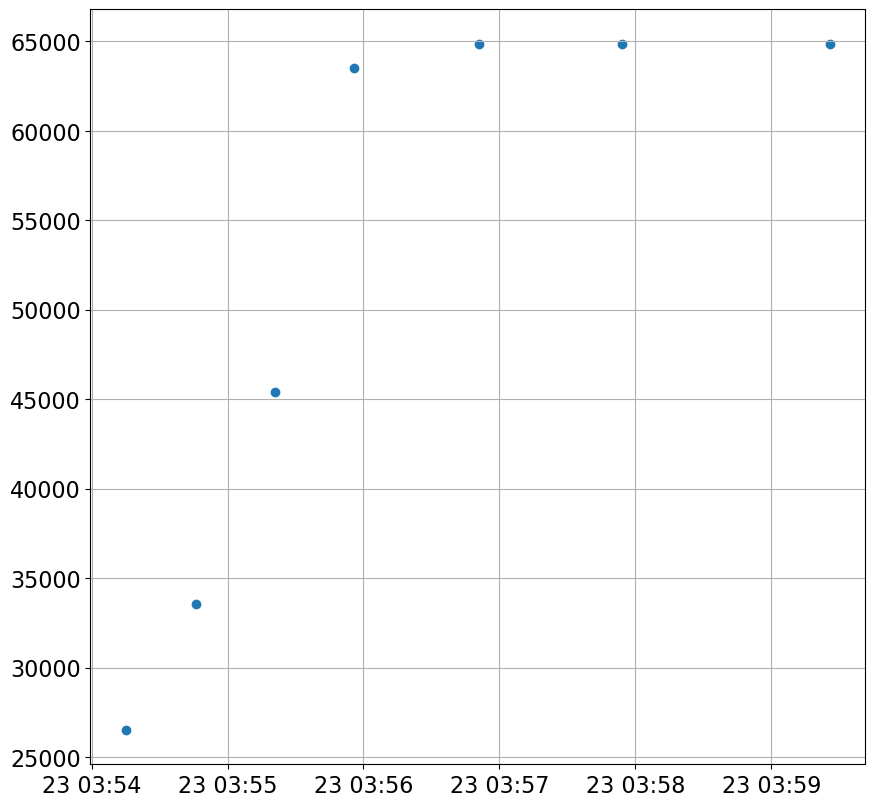

In [17]:
plt.scatter(times,avg)

<b> we see the plot even off at the top because we've reached the peak values obtainable but it is linear throughout

## 3. Use photutils to perform aperture photometry on three (non saturated) stars in the PG1633+099 standard field: a really faint one, a medium bright one, and a bright one. Perform aperture photometry using at least 5 aperture sizes from very small to very large and make a plot that reproduces the one from Howell Figure 5.7 showing S/N as a function of aperture radius. What is a good aperture size to use for this dataset?

In [18]:
# insert the position of three stars found in ds9
x1 = 529
x2 = 1260
x3 = 250
y1 = 603
y2 = 1224
y3 = 543
positions = [(x1,y1),(x2,y2),(x3,y3)]

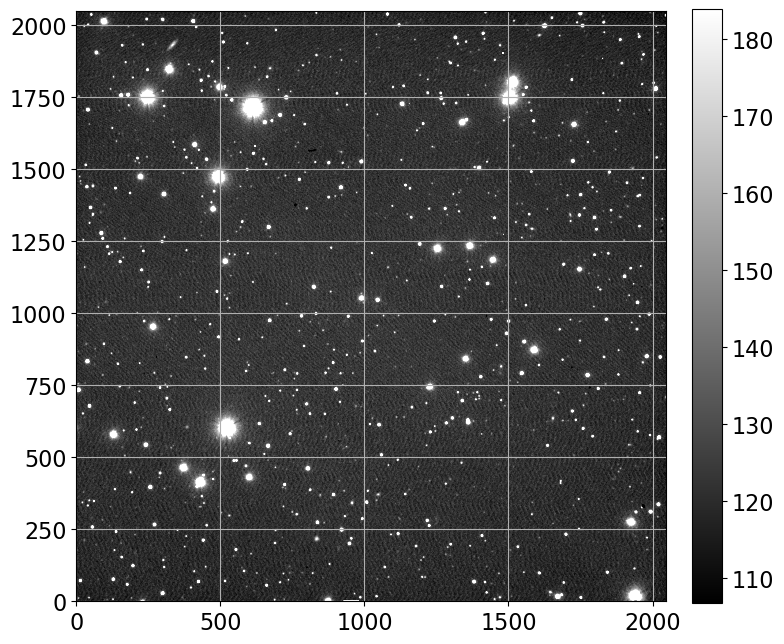

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show_image(sci, cmap='gray', ax=ax, fig=fig)

#plt.xlim
plt.tight_layout()
plt.show()

In [20]:
mean, median, std = sigma_clipped_stats(sci, sigma=3.0)  

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)

sources = daofind(sci-median) 

In [21]:
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)

 id xcentroid ycentroid  sharpness  ... sky    peak      flux       mag    
--- --------- ---------- ---------- ... --- --------- --------- -----------
  1 873.52339 0.75103259 0.35696949 ...   0  32598.56 448.08652  -6.6284047
  2 688.01641  3.9544341 0.52238486 ...   0 182.26942 1.6610927 -0.55098466
  3 127.70436  5.5044656 0.29559194 ...   0 134.77294 1.6701923 -0.55691618
  4 1450.2344   6.083625 0.39210049 ...   0 121.15659 1.1529701 -0.15454515
  5 7.9991143  9.4836982 0.43333709 ...   0 94.872519 1.2079519  -0.2051241
  6 44.602839  11.235481 0.47752998 ...   0 140.09176 1.8283604 -0.65515452
  7 984.72106  12.315191 0.49716929 ...   0 393.50108 3.8352811   -1.459493
...       ...        ...        ... ... ...       ...       ...         ...
584 1648.6293  2020.9363 0.38084012 ...   0 456.68007   4.83572  -1.7111529
585  2044.991  2029.4763 0.43880268 ...   0 667.76246 6.6602082  -2.0587195
586 52.447029  2032.1257 0.45821664 ...   0 517.07165 5.0621304  -1.7608333
587 1078.555

In [22]:
circ_aperture    = CircularAperture(positions, r=1)
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

circ_aperture2    = CircularAperture(positions, r=2)

circ_aperture3    = CircularAperture(positions, r=3)

circ_aperture4    = CircularAperture(positions, r=4)

circ_aperture5    = CircularAperture(positions, r=5)

circ_aperture6    = CircularAperture(positions, r=6)

circ_aperture7    = CircularAperture(positions, r=7)

circ_aperture8    = CircularAperture(positions, r=8)

circ_aperture9    = CircularAperture(positions, r=9)

circ_aperture10    = CircularAperture(positions, r=10)

circ_aperture11   = CircularAperture(positions, r=11)

circ_aperture12    = CircularAperture(positions, r=12)

circ_aperture13   = CircularAperture(positions, r=13)

allaps = [circ_aperture, circ_aperture2, circ_aperture3, circ_aperture4, circ_aperture5, circ_aperture6, circ_aperture7, circ_aperture8, circ_aperture9, circ_aperture10, circ_aperture11, circ_aperture12,circ_aperture13]

In [23]:
brightest = []
bright = []
faint = []

for ap in allaps:
    apers = [ap, annulus_aperture]
    phot_table = aperture_photometry(sci, apers)
    for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'  # for consistent table output
    print(phot_table)
    S = phot_table['aperture_sum_0']

    A = ap.area

    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    
    bkg_sum = bkg_mean * ap.area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output
    print(phot_table['residual_aperture_sum'])  
    T = S - (A*bkg_mean)

    TT = ((T) + (A*bkg_mean))

    SN = (T)/np.sqrt((T)+(A*bkg_mean))
    
    brightest.append(SN[0])
    bright.append(SN[1])
    faint.append(SN[2])

 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1     529     603      7786.6204      2314708.3
  2    1260    1224      821.96578      324350.18
  3     250     543      464.74815      90963.281
residual_aperture_sum
---------------------
           -10731.046
           -1772.8357
            -262.9581
 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1     529     603      35065.402      2314708.3
  2    1260    1224      3569.5896      324350.18
  3     250     543       1817.007      90963.281
residual_aperture_sum
---------------------
           -39005.264
           -6809.6163
            -1093.818
 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1     529     603      99433

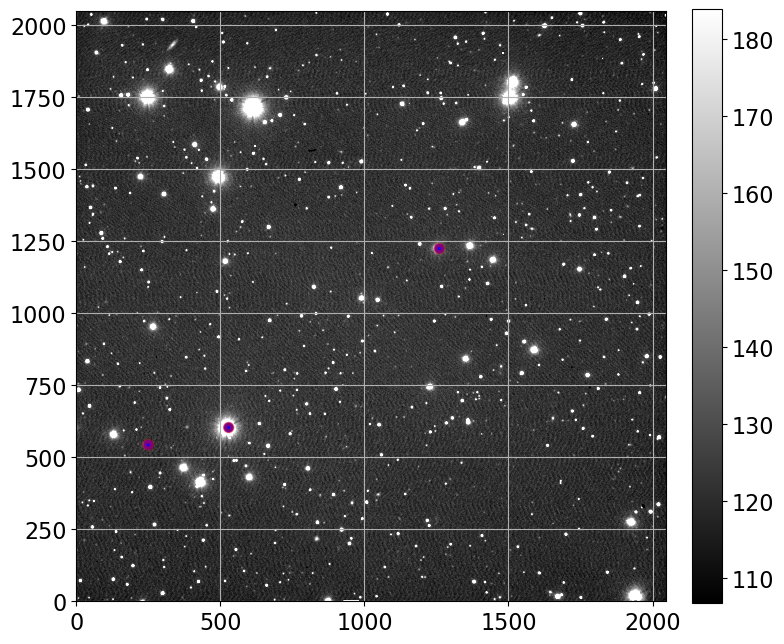

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show_image(sci, cmap='gray', ax=ax, fig=fig)
for i in (allaps):
    i.plot(color='blue', lw=2, alpha=0.5) 
annulus_aperture.plot(color='red', lw=2, alpha=0.5) # apertures
#ax.set_xlim([1100,1500]) # use these to zoom in/out
#ax.set_ylim([1100,1500])
plt.tight_layout()

plt.show()

<b> I tried to index the plot so it would come out clearer but I kept getting regions without the defined stars, however the density of blue you can see in the image is evident of the multiple aperatures represented in a single image

In [25]:
#apers = [circ_aperture10, annulus_aperture]
#phot_table = aperture_photometry(sci, apers)
#for col in phot_table.colnames:
#    phot_table[col].info.format = '%.8g'  # for consistent table output
#print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1     529     603      4869054.3      2314708.3
  2    1260    1224      839162.45      324350.18
  3     250     543      167461.33      90963.281


In [38]:
radii = [1,2,3,4,5,6,7,8,9,10,11,12,13]


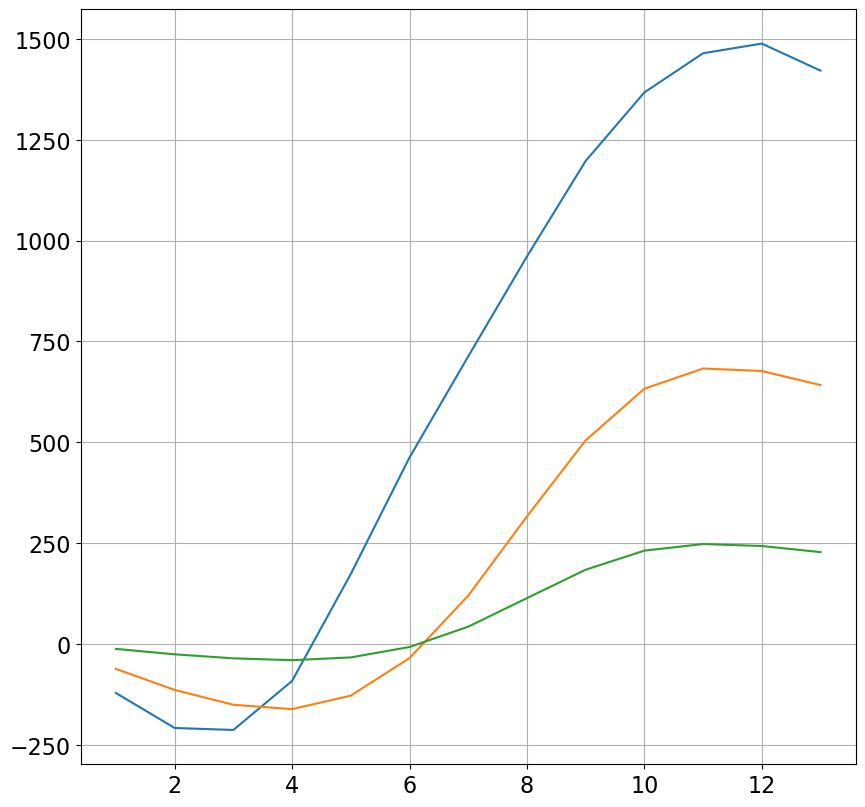

In [39]:
plt.plot(radii,brightest)
plt.plot(radii,bright)
plt.plot(radii,faint)

<b> This is sort of what we want even though it's inverted for reasons I haven't figured out. The likely reason for the negative dip is due to the disparity in the ratio of radius to background at such low radii.

## 4. Identify the standard stars in the PG1633+099 frame from Landolt (1992).

Where they are in ds9 (fun fact the image is upside down)

1. x = 991.4 y = 1048.6
A. x = 1047.09 y = 1043.19
B. x = 1253.91  y = 1222.1
C. x = 1365.76 y = 1230.81
D. x = 1445.47 y = 1181.91

Mag in Landolt(1992)

1. 6
A. 6
B. 6
C. 6
D. 5


## 5. Extract instrumental magnitudes for the UBVRI filters for all of your standard stars using an approach that you’ve advocated for as best you can in the questions above.

##  put instrumental mag on photometric system
V = V_naut + C_zv + C_1,v(b_naut - V_naut)

V - V_naut = dff between instrumental mag and true

need to know true colors and true magnitudes
plt V-V_naut vs. b_naut - V_naut

## to do the last one make a loop of each filter (select all the science frames in that filter) then loop over the actual science frames and do the photometry

def get_phot(img,guess_pos,do_plots)
    find stars w/ starfinder
    # read in the data

    select good positions for the standards
    aperatures and backgrounds

In [ ]:
imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='*otzf.fits')
print(imgs.files_filtered(object = 'pg1633', imagetyp = 'science',include_path=True))

In [ ]:
def filtered(filtertype):
    #filtertype = input('')
    files = imgs.files_filtered(object='pg1633',imagetyp = 'science',filter=filtertype,include_path=True)
    hdus = [fits.open(file) for file in files]
    hdrs = [hdu[0].header for hdu in hdus]
    lin = [hdu[0].data[1000:1300,800:1500] for hdu in hdus]
    
    for array in lin:
        mean, median, std = sigma_clipped_stats(array, sigma=3.0)  

        daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)

        sources = daofind(array-median)
    
        for col in sources.colnames:  
            sources[col].info.format = '%.8g'  # for consistent table output
        
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        
        circ_aperture    = CircularAperture(positions, r=5)
        annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)
        
        apers = [circ_aperture, annulus_aperture]
        phot_table = aperture_photometry(array, apers)
        for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'  # for consistent table output
        
        S = phot_table['aperture_sum_0']
        A = circ_aperture.area
        bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
        
        bkg_sum = bkg_mean * circ_aperture.area
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['residual_aperture_sum'] = final_sum
        phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output
        
        m = -2.5*np.log(phot_table['residual_aperture_sum'])
        phot_table['instrumental_magnitude'] = m
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        show_image(array, cmap='gray', ax=ax, fig=fig)
        circ_aperture.plot(color='blue', lw=2, alpha=0.5) 
        annulus_aperture.plot(color='red', lw=2, alpha=0.5) # apertures
        #ax.set_xlim([1100,1500]) # use these to zoom in/out
        #ax.set_ylim([1100,1500])
        plt.tight_layout()
    
        
        plt.show()

    return (phot_table)

In [ ]:
filtered('U')

In [ ]:
filters=['U','B','V','R','I']
for filt in filters:
    filtered(filt)

# Comments

This sort of worked out the only issue is that I have to do a bit more work on cutting out extra stars. Very close though I think